In [63]:
from utils import *

In [64]:
ch2 = EntireModel("CH2.csv")

ch2_pipeline = {"oneHotEncode" : [0],
                "normalize" : [0, 1],
                "split" : [1, 0.2, 0],
                "PCA" : [1, 0.9999],
                "KNN" : [1, 11]}

ch2.run(ch2_pipeline)



0.7197696737044146


c:\Users\Lohith\miniconda3\envs\tensor\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [65]:
ch3 = EntireModel("CH3.csv")

ch3_pipeline = {"oneHotEncode" : [0],
                "normalize" : [0, 1],
                "split" : [1, 0.2, 0],
                "PCA" : [1, 0.9999],
                "KNN" : [1, 11]}

ch3.run(ch3_pipeline)

0.7696737044145874


c:\Users\Lohith\miniconda3\envs\tensor\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [66]:
ch4 = EntireModel("CH4.csv")

ch4_pipeline = {"oneHotEncode" : [0],
                "normalize" : [0, 1],
                "split" : [1, 0.2, 0],
                "PCA" : [1, 0.9999],
                "KNN" : [1, 11]}

ch4.run(ch4_pipeline)

0.8214971209213052


c:\Users\Lohith\miniconda3\envs\tensor\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [67]:
ch2_pred = np.reshape(ch2.predict(), (-1,1))
ch3_pred = np.reshape(ch3.predict(), (-1,1))
ch4_pred = np.reshape(ch4.predict(), (-1,1))

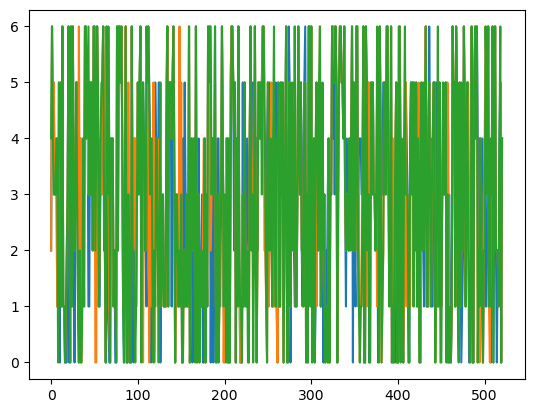

In [68]:
import matplotlib.pyplot as plt

plt.plot((ch2_pred))
plt.plot((ch3_pred))
plt.plot((ch4_pred))

In [69]:
predictions = np.concatenate((ch2_pred, ch3_pred, ch4_pred), axis = 1)

In [70]:
predictions = predictions.astype("int64")

In [71]:
x = np.array([[1,1,0],
              [0,0,1]])

maxOccur = lambda x : np.bincount(x).argmax()

In [72]:
from sklearn.metrics import accuracy_score

accuracy_score(list(map(maxOccur, predictions)), ch2.Y_test)

0.8502879078694817